In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import pickle
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
import spacy
import spacy.cli
from scipy import spatial
spacy.cli.download("en_core_web_md")
nlp = spacy.load('en_core_web_md')

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


Definition of a plot function for training result visualization

In [ ]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)
    
    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)
    
    plt.show();

IMDB database loading

In [ ]:
# Mounting the google drive to google colab in order to load the data files directly from it
from google.colab import drive
drive.mount('/content/drive')
imdb_df = pd.read_csv("/content/drive/MyDrive/EPITA_NLP/Course2/IMDB Dataset.csv")

Mounted at /content/drive


In [ ]:
# These data from IMDB correspond to movie review, with sentiment (postive/negative) labels
imdb_df.head

<bound method NDFrame.head of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

In [ ]:
len(imdb_df)

50000

## Preprocessing of the data

We get the IMDB dataset

Here is the original code to transform the texts into 300-dimension embedding vectors with spaCy pretrained model.
However, in order to save most of the computation time needed, we just do the operation **on a small subsample** of the complete data. On the **next cells**, we load directly the **embedding already computed on all the data** to use it directly.

Let's have a look to an example of review

In [ ]:
review_example = imdb_df["review"][0]
review_example

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

Let's see how to use spaCy to turn it into a 300-dimension **text** embedding vector

In [ ]:
text_embedding_example =  nlp(review_example).vector
text_embedding_example

array([-5.20629659e-02,  1.76978067e-01, -1.36168167e-01, -6.55549467e-02,
        8.32999498e-02,  5.18484507e-04, -2.14118673e-03, -6.22530282e-02,
       -2.49865353e-02,  2.13308358e+00, -1.38473496e-01,  3.26936096e-02,
        8.59473571e-02, -5.60004413e-02, -1.12932213e-01, -9.65132043e-02,
       -3.17423567e-02,  9.75738585e-01, -1.56550646e-01, -7.16082603e-02,
       -1.80443656e-02, -3.17366049e-02, -3.79024597e-04, -4.56468649e-02,
        6.40577450e-03, -4.15311456e-02, -6.01521805e-02, -4.16227020e-02,
        3.81650440e-02, -8.43040571e-02, -1.43980384e-02,  7.13374242e-02,
       -1.08500592e-01,  5.42309806e-02,  8.28847885e-02, -7.41668269e-02,
       -1.18786804e-02,  1.89229008e-02, -6.50422573e-02, -2.43393127e-02,
       -5.95263997e-03,  4.83228900e-02,  3.24534215e-02, -8.49065483e-02,
        5.93352094e-02,  5.37182428e-02, -1.43510342e-01, -2.45821830e-02,
       -1.49022473e-03, -5.05763246e-03, -4.17294949e-02,  6.87651709e-02,
       -1.97180621e-02,  

In [ ]:
text_embedding_example.shape

(300,)

As explained just before, we only compute the embedding on the 100 first element in order to avoid a too long computation time

In [ ]:
size_data = 100#len(test_df)
list_embed = [float('nan')] * size_data
list_label = [float('nan')] * size_data

compt = 0
for sentence in list(imdb_df.itertuples())[0:size_data]:
    text_embed = nlp(sentence.review).vector
    observed_sentiment = sentence.sentiment
    if  observed_sentiment=="positive":
      label = 1.0
    else:
      label = 0.0
    list_embed[compt] = np.asarray(text_embed, dtype ="float32").reshape(1,300)
    list_label[compt] = label
    compt += 1

In [ ]:
print(list_label)

[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]


In [ ]:
len(list_embed)

100

To save time processing, we download the **embeddings already computed on the complete dataset**. It may take some time anyway but it is still much less than doing the whole operation once again.

In [ ]:
df_imdb_embed_label = pd.read_pickle("/content/drive/MyDrive/EPITA_NLP/Course2/df_imdb_embed_label.pkl")
list_embed = list(df_imdb_embed_label["embedding"])
list_label = list(df_imdb_embed_label["label"])

In [ ]:
len(list_embed)

50000

## Use of a neural network to perform sentiment analysis from the spaCy embeddings

## Neural network model definition

In [ ]:
model = tf.keras.models.Sequential([
    Dense(300, activation="relu"),
    Dropout(rate=0.8),
    Dense(128, activation="relu"),
    Dense(128, activation="relu"),
    Dropout(rate=0.8),
    Dense(1, activation="sigmoid")
])

We build the model and check that everything is fine

In [ ]:
model(list_embed[0])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (1, 300)                  90300     
_________________________________________________________________
dropout (Dropout)            (1, 300)                  0         
_________________________________________________________________
dense_1 (Dense)              (1, 128)                  38528     
_________________________________________________________________
dense_2 (Dense)              (1, 128)                  16512     
_________________________________________________________________
dropout_1 (Dropout)          (1, 128)                  0         
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    129       
Total params: 145,469
Trainable params: 145,469
Non-trainable params: 0
__________________________________________________

We compile the model, choosing relevant loss function, optimizer and metrics

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

We train the model on the dataset

In [ ]:
n_dim_embedding = 300
size_data = 10000
array_embed = np.asarray(list_embed[0:size_data]).reshape(size_data,n_dim_embedding)
array_label = np.asarray(list_label[0:size_data])

In [ ]:
history = model.fit(x = array_embed, y = array_label, epochs = 80, batch_size= 500, validation_split=0.1)

Epoch 1/80
18/18 [==============================] - 1s 30ms/step - loss: 0.7016 - accuracy: 0.5126 - val_loss: 0.6852 - val_accuracy: 0.7090
Epoch 2/80
18/18 [==============================] - 0s 20ms/step - loss: 0.6826 - accuracy: 0.5558 - val_loss: 0.6576 - val_accuracy: 0.7260
Epoch 3/80
18/18 [==============================] - 0s 17ms/step - loss: 0.6477 - accuracy: 0.6372 - val_loss: 0.5848 - val_accuracy: 0.7440
Epoch 4/80
18/18 [==============================] - 0s 17ms/step - loss: 0.5746 - accuracy: 0.7229 - val_loss: 0.4926 - val_accuracy: 0.7810
Epoch 5/80
18/18 [==============================] - 0s 17ms/step - loss: 0.5130 - accuracy: 0.7654 - val_loss: 0.4443 - val_accuracy: 0.7920
Epoch 6/80
18/18 [==============================] - 0s 16ms/step - loss: 0.4751 - accuracy: 0.7869 - val_loss: 0.4232 - val_accuracy: 0.7990
Epoch 7/80
18/18 [==============================] - 0s 17ms/step - loss: 0.4655 - accuracy: 0.7957 - val_loss: 0.4077 - val_accuracy: 0.8240
Epoch 8/80
18

## Result visualization

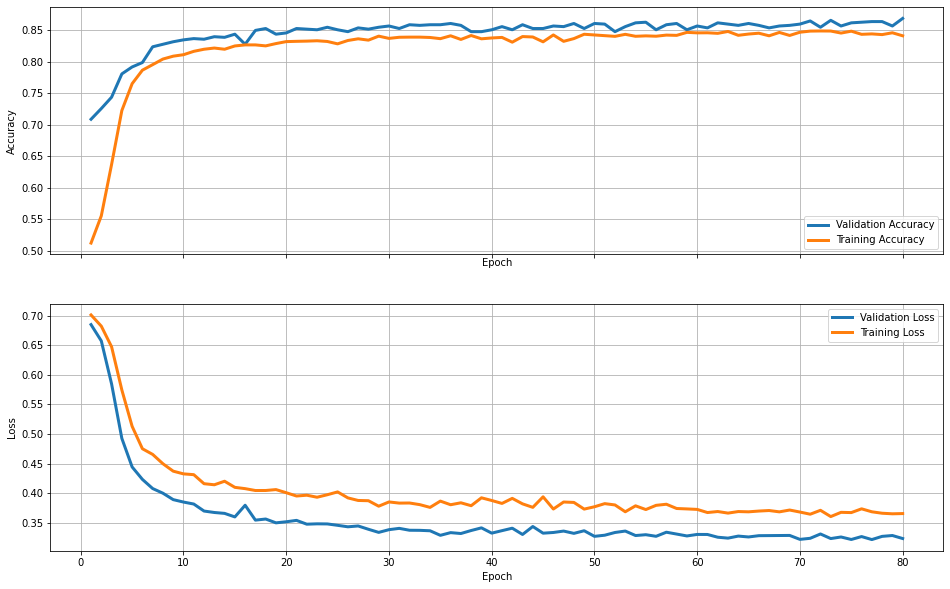

In [ ]:
plot_results(history)